In [3]:
import numpy as np
import pandas as pd
import itertools 
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Conv2D, Input, Dense, MaxPool2D,BatchNormalization,Flatten,ZeroPadding2D,Activation,Dropout,LSTM
from keras.layers import TimeDistributed
from keras.models import Model,Sequential
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
%matplotlib inline

In [13]:
import keras.backend.tensorflow_backend as tfback
def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

In classifier model I have removed the Sotftmax Layer and added a Dense layer to give embedding of length 128.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
def classifierModel(X_input):
  '''
  Layer 1
  '''
  X = TimeDistributed(Conv2D(64,(7,7),strides=(2,2),name = 'conv2',activation='relu'))(X_input)
  X = TimeDistributed(MaxPool2D((3,3),strides=(2,2),name='max_pool2'))(X)
  X = TimeDistributed(BatchNormalization())(X)

  '''
  Layer 2
  '''
  X1 = TimeDistributed(Conv2D(96,(1,1),name='conv4',activation='relu'))(X)
  X2 = TimeDistributed(MaxPool2D((3,3),strides=(1,1),name='max_pool3'))(X)
  X3 = TimeDistributed(Conv2D(208,(3,3),name='conv5',activation='relu'))(X1)
  X4 = TimeDistributed(Conv2D(64,(1,1),name='conv6',activation='relu'))(X2)
  print(X1.shape,X2.shape)
  chunk_1 = keras.layers.concatenate([X3,X4],axis=-1)

  '''
  Layer 3
  '''
  X5 = TimeDistributed(Conv2D(96,(1,1),name='conv7',activation='relu'))(chunk_1)
  X6 = TimeDistributed(MaxPool2D((3,3),strides=(1,1),name='max_pool4'))(chunk_1)
  X7 = TimeDistributed(Conv2D(208, (3,3),name='conv8',activation='relu'))(X5)
  X8 = TimeDistributed(Conv2D(64,(1,1),name='conv9',activation='relu'))(X6)
  chunk_2 = keras.layers.concatenate([X7,X8],axis=-1)
  '''
  Layer 4
  '''
  out = TimeDistributed(Flatten())(chunk_2)
  out = TimeDistributed(Dropout(0.5))(out)
  out = TimeDistributed(Dense(128,activation = 'linear'))(out)
  return out


1. Clip size will be fixed i.e. the number of images during transition of emotion.
2. s0 and c0 are the initial hidden state and cell state for LSTM
3. Outputs will be an array storing the output of each LSTM cell 
4. Then we will take the last output of LSTM cell as our final output 

In [10]:
def LSTM_model(input_shape):
  X_input = Input(shape = input_shape)
  X = classifierModel(X_input)
  X = LSTM(128)(X)
  X = Dense(8,activation='softmax')(X)
  model = Model(inputs = X_input,outputs = X)
  return model

Clip size yet to be decided and it will be same as hidden_state_size because there will be equal number of LSTM units as number of images in a clip.


In [11]:
model1 = LSTM_model((12,48,48,1))

(None, 12, 10, 10, 96) (None, 12, 8, 8, 64)


In [12]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()  

In [45]:
emotion_model = keras.models.load_model('/content/drive/My Drive/data/training3.h5')

In [46]:
emotion_model.layers.pop()
emotion_model.layers.pop()
emotion_model.layers.pop()
emotion_model.outputs = [emotion_model.layers[-1].output]

In [69]:
def fine_tune(input_shape):
  input = Input(shape=input_shape, name='seq_input')
  x = TimeDistributed(keras.layers.Lambda(lambda x: emotion_model(x)))(input)
  x = TimeDistributed(Flatten())(x)
  x = TimeDistributed(Dense(128))(x)
  x = LSTM(128)(x)
  out = Dense(8,activation='softmax')(x)
  model = Model(inputs = input,outputs = out)
  return model

In [70]:
fine_tuned_model = fine_tune((12,48,48,1))

In [71]:
fine_tuned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Downloading BAUM 2 Dataset from the official website and extracting it to videos folder

Getting cascades to find face and eye

Extracting frames from the video file to use our model on that.

In [5]:
!wget --continue https://github.com/spazewalker/FER_Doggomaniacs/raw/master/Video/ds.zip https://github.com/spazewalker/FER_Doggomaniacs/raw/master/main1.csv && unzip ds.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/S274/004/frames/6.jpg  
  inflating: dataset/S274/004/frames/3.jpg  
  inflating: dataset/S274/004/frames/9.jpg  
  inflating: dataset/S274/004/frames/1.jpg  
  inflating: dataset/S274/004/frames/2.jpg  
  inflating: dataset/S274/004/frames/4.jpg  
  inflating: dataset/S274/004/frames/8.jpg  
  inflating: dataset/S274/004/frames/0.jpg  
  inflating: dataset/S274/004/frames/5.jpg  
  inflating: dataset/S274/004/frames/11.jpg  
   creating: dataset/S274/006/
  inflating: dataset/S274/006/emotion.txt  
   creating: dataset/S274/006/frames/
  inflating: dataset/S274/006/frames/7.jpg  
  inflating: dataset/S274/006/frames/10.jpg  
  inflating: dataset/S274/006/frames/6.jpg  
  inflating: dataset/S274/006/frames/3.jpg  
  inflating: dataset/S274/006/frames/9.jpg  
  inflating: dataset/S274/006/frames/1.jpg  
  inflating: dataset/S274/006/frames/2.jpg  
  inflating: dataset/S274/006/frames/4.jpg  
  inflating: dataset/S27

In [6]:
ds = pd.read_csv("main1.csv")
ds.head()

,frames,emotion
0,dataset/S001/001/frames/,7
1,dataset/S002/001/frames/,2
2,dataset/S002/002/frames/,5
3,dataset/S003/001/frames/,5
4,dataset/S004/001/frames/,5


In [7]:
x = np.array(ds['frames'])
y = pd.get_dummies(ds['emotion']).to_numpy()

In [8]:
import cv2
import numpy as np

count = len(x)

data = np.empty((1,1,1))
print("data loading. ")
for j in range(len(x)):
    for i in range(12):
        arr = cv2.imread(x[j]+str(i)+'.jpg',cv2.IMREAD_GRAYSCALE)
        data = np.append(data,arr)
        print('\r{}%'.format(j/len(x)*100),end='')
        # print(arr.shape)
        # break
data = np.delete(data,0)
data = data.reshape(count,12,48,48,1)
print('\r100%\nFinal Shape: ',data.shape)

data loading. 
100%
Final Shape:  (883, 12, 48, 48, 1)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=42)

Input_frames are of shape (m,clip_size,input_size)
where input_size for eg. for FER2013 is (48,48,1)

In [7]:
print('X_train: ',X_train.shape,'\nX_test: ',X_test.shape,'\ny_train: ',y_train.shape,'\ny_test: ',y_test.shape)

X_train:  (794, 12, 48, 48, 1) 
X_test:  (89, 12, 48, 48, 1) 
y_train:  (794, 8) 
y_test:  (89, 8)


In [72]:
fine_tuned_model.fit(X_train,y_train,epochs=8,batch_size = 32,validation_data=(X_test,y_test))

Train on 794 samples, validate on 89 samples
Epoch 1/8
794/794 [==============================] - 2s 3ms/step - loss: 1.7289 - accuracy: 0.3640 - val_loss: 1.5542 - val_accuracy: 0.3258
Epoch 2/8
794/794 [==============================] - 1s 1ms/step - loss: 0.7883 - accuracy: 0.7796 - val_loss: 1.5573 - val_accuracy: 0.4494
Epoch 3/8
794/794 [==============================] - 1s 2ms/step - loss: 0.1982 - accuracy: 0.9622 - val_loss: 1.9606 - val_accuracy: 0.4157
Epoch 4/8
794/794 [==============================] - 1s 1ms/step - loss: 0.0610 - accuracy: 0.9874 - val_loss: 2.3705 - val_accuracy: 0.4270
Epoch 5/8
794/794 [==============================] - 1s 2ms/step - loss: 0.0171 - accuracy: 0.9987 - val_loss: 2.2940 - val_accuracy: 0.4045
Epoch 6/8
794/794 [==============================] - 1s 1ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 2.4932 - val_accuracy: 0.4607
Epoch 7/8
794/794 [==============================] - 1s 1ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss

In [73]:
kf = KFold(n_splits=10)
kf.get_n_splits(x)
print(kf)
fine_tuned_model2 = fine_tune((12,48,48,1))
fine_tuned_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for train_index,test_index in kf.split(X_train,y_train):

  X_train_sub, X_test_sub = X_train[train_index], X_train[test_index]
  y_train_sub, y_test_sub = y_train[train_index], y_train[test_index]
  X_train_sub = X_train_sub.reshape(X_train_sub.shape[0],12,48, 48, 1)
  X_test_sub = X_test_sub.reshape(X_test_sub.shape[0],12,48, 48, 1)

  fine_tuned_model2.fit(X_train_sub,y_train_sub,epochs=5,batch_size=32,validation_data=(X_test_sub,y_test_sub))

KFold(n_splits=10, random_state=None, shuffle=False)
Train on 714 samples, validate on 80 samples
Epoch 1/5
714/714 [==============================] - 2s 3ms/step - loss: 1.7243 - accuracy: 0.3739 - val_loss: 1.6344 - val_accuracy: 0.3750
Epoch 2/5
714/714 [==============================] - 1s 2ms/step - loss: 0.8257 - accuracy: 0.7689 - val_loss: 1.8254 - val_accuracy: 0.4250
Epoch 3/5
714/714 [==============================] - 1s 2ms/step - loss: 0.2284 - accuracy: 0.9510 - val_loss: 2.2281 - val_accuracy: 0.4125
Epoch 4/5
714/714 [==============================] - 1s 2ms/step - loss: 0.0462 - accuracy: 0.9972 - val_loss: 2.7236 - val_accuracy: 0.3875
Epoch 5/5
714/714 [==============================] - 1s 2ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 3.2113 - val_accuracy: 0.3750
Train on 714 samples, validate on 80 samples
Epoch 1/5
714/714 [==============================] - 1s 2ms/step - loss: 0.3357 - accuracy: 0.9258 - val_loss: 0.6461 - val_accuracy: 0.7500
Epoch 2/5
7

In [84]:
from keras.layers import Conv3D,MaxPool3D
def c3d_model(input_shape):
  input = Input(shape = input_shape)
  X = Conv3D(64,(1,3,3),activation = 'relu')(input)
  X = MaxPool3D((1,2,2),strides=(1,2,2))(X)
  X = Conv3D(128,(1,3,3),activation='relu')(X)
  X = MaxPool3D((1,2,2),strides=(2,2,2))(X)
  X = Conv3D(128,(1,1,1),activation='relu')(X)
  X = Conv3D(256,(1,1,1),activation = 'relu')(X)
  X = MaxPool3D((2,2,2),strides=(2,2,2))(X)
  X = Conv3D(256,(1,1,1),activation='relu')(X)
  X = Conv3D(512,(1,1,1),activation='relu')(X)
  X = MaxPool3D((2,2,2),strides=(2,2,2))(X)
  X = Conv3D(512,(1,1,1),activation='relu')(X)
  X = Conv3D(512,(1,1,1),activation='relu')(X)
  X = MaxPool3D((1,1,1),strides=(2,2,2))(X)
  X = Flatten()(X)
  X = Dense(4096)(X)
  X = Dropout(0.5)(X)
  X = Dense(4096)(X)
  X = Dropout(0.5)(X)
  out = Dense(8,activation='softmax')(X)
  model = Model(inputs = input,outputs = out)
  return model

In [78]:
c3d = c3d_model((12,48,48,1))

In [82]:
c3d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
c3d.fit(X_train,y_train,epochs=5,batch_size=32,validation_data=(X_test,y_test))

Train on 794 samples, validate on 89 samples
Epoch 1/5
794/794 [==============================] - 5s 6ms/step - loss: 4.3781 - accuracy: 0.1814 - val_loss: 1.9460 - val_accuracy: 0.2472
Epoch 2/5
794/794 [==============================] - 4s 5ms/step - loss: 1.9968 - accuracy: 0.2053 - val_loss: 1.9585 - val_accuracy: 0.1348
Epoch 3/5
794/794 [==============================] - 4s 5ms/step - loss: 1.9853 - accuracy: 0.2141 - val_loss: 1.9162 - val_accuracy: 0.2472
Epoch 4/5
794/794 [==============================] - 4s 5ms/step - loss: 1.9803 - accuracy: 0.2040 - val_loss: 1.9151 - val_accuracy: 0.2472
Epoch 5/5
794/794 [==============================] - 4s 5ms/step - loss: 1.9789 - accuracy: 0.2003 - val_loss: 1.9596 - val_accuracy: 0.2247


In [89]:
kf = KFold(n_splits=10)
kf.get_n_splits(x)
print(kf)
c3d = c3d_model((12,48,48,1))
c3d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for train_index,test_index in kf.split(X_train,y_train):

  X_train_sub, X_test_sub = X_train[train_index], X_train[test_index]
  y_train_sub, y_test_sub = y_train[train_index], y_train[test_index]
  X_train_sub = X_train_sub.reshape(X_train_sub.shape[0],12,48, 48, 1)
  X_test_sub = X_test_sub.reshape(X_test_sub.shape[0],12,48, 48, 1)

  c3d.fit(X_train_sub,y_train_sub,epochs=10,batch_size=32,validation_data=(X_test_sub,y_test_sub))

KFold(n_splits=10, random_state=None, shuffle=False)
Train on 714 samples, validate on 80 samples
Epoch 1/10
714/714 [==============================] - 4s 6ms/step - loss: 4.3428 - accuracy: 0.1667 - val_loss: 2.1707 - val_accuracy: 0.2000
Epoch 2/10
714/714 [==============================] - 4s 5ms/step - loss: 2.0004 - accuracy: 0.2059 - val_loss: 1.9383 - val_accuracy: 0.2000
Epoch 3/10
714/714 [==============================] - 4s 5ms/step - loss: 1.9742 - accuracy: 0.2283 - val_loss: 2.0393 - val_accuracy: 0.2000
Epoch 4/10
714/714 [==============================] - 4s 5ms/step - loss: 1.9790 - accuracy: 0.2171 - val_loss: 1.9980 - val_accuracy: 0.2000
Epoch 5/10
714/714 [==============================] - 4s 5ms/step - loss: 1.9695 - accuracy: 0.2339 - val_loss: 1.9512 - val_accuracy: 0.2250
Epoch 6/10
714/714 [==============================] - 4s 5ms/step - loss: 1.9810 - accuracy: 0.2269 - val_loss: 1.9908 - val_accuracy: 0.1375
Epoch 7/10
714/714 [==============================

In [39]:
class_names = ['Neutral', 'Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Sad','Suprise']
def plot_confusion_matrix(
        cm,
        classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,color = 'black')
    plt.yticks(tick_marks, classes,color = 'black')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12,color='black')
    plt.xlabel('Predicted label', fontsize=12,color='black')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')

In [53]:
ans = np.argmax(fine_tuned_model2.predict(X_test),axis=-1)
y_test_fine = np.argmax(y_test,axis=1)

Normalized confusion matrix
[[0.45       0.2        0.         0.15       0.         0.
  0.1        0.1       ]
 [0.26315789 0.47368421 0.         0.         0.         0.05263158
  0.05263158 0.15789474]
 [0.5        0.         0.         0.         0.         0.
  0.5        0.        ]
 [0.33333333 0.33333333 0.         0.33333333 0.         0.
  0.         0.        ]
 [0.2        0.         0.         0.         0.2        0.2
  0.         0.4       ]
 [0.09090909 0.04545455 0.         0.04545455 0.         0.77272727
  0.04545455 0.        ]
 [0.5        0.         0.         0.         0.         0.
  0.33333333 0.16666667]
 [0.08333333 0.33333333 0.         0.         0.08333333 0.08333333
  0.08333333 0.33333333]]


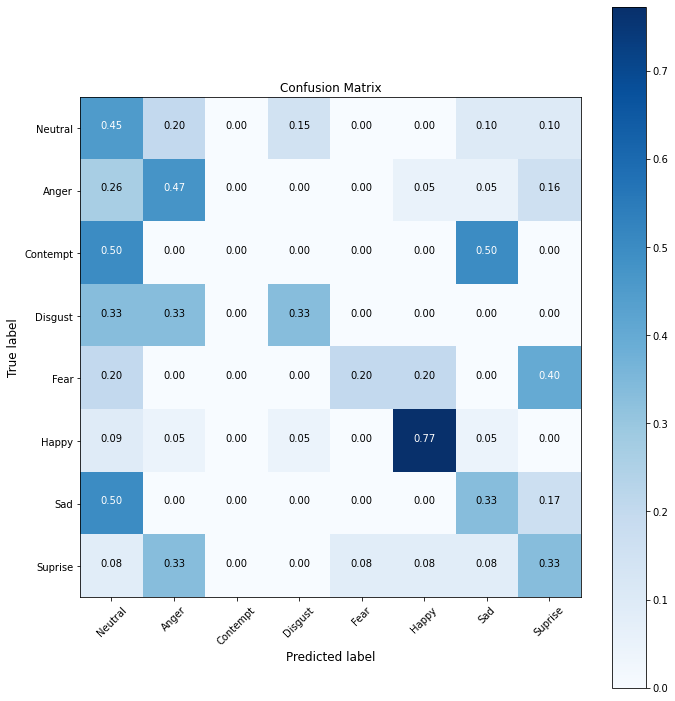

In [54]:
matrix = confusion_matrix(y_test_fine,ans)
plot_confusion_matrix(
        matrix,
        classes=class_names,
        normalize=True,
        title='Confusion Matrix')

In [86]:
ans = np.argmax(c3d.predict(X_test),axis=-1)
y_test_c3d = np.argmax(y_test,axis=1)

Normalized confusion matrix
[[0.1        0.4        0.         0.         0.         0.4
  0.1        0.        ]
 [0.05263158 0.52631579 0.         0.         0.         0.36842105
  0.         0.05263158]
 [0.5        0.         0.         0.         0.         0.
  0.5        0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.        ]
 [0.2        0.2        0.         0.         0.         0.6
  0.         0.        ]
 [0.09090909 0.40909091 0.         0.         0.         0.36363636
  0.09090909 0.04545455]
 [0.         0.16666667 0.         0.16666667 0.         0.66666667
  0.         0.        ]
 [0.08333333 0.58333333 0.         0.         0.         0.33333333
  0.         0.        ]]


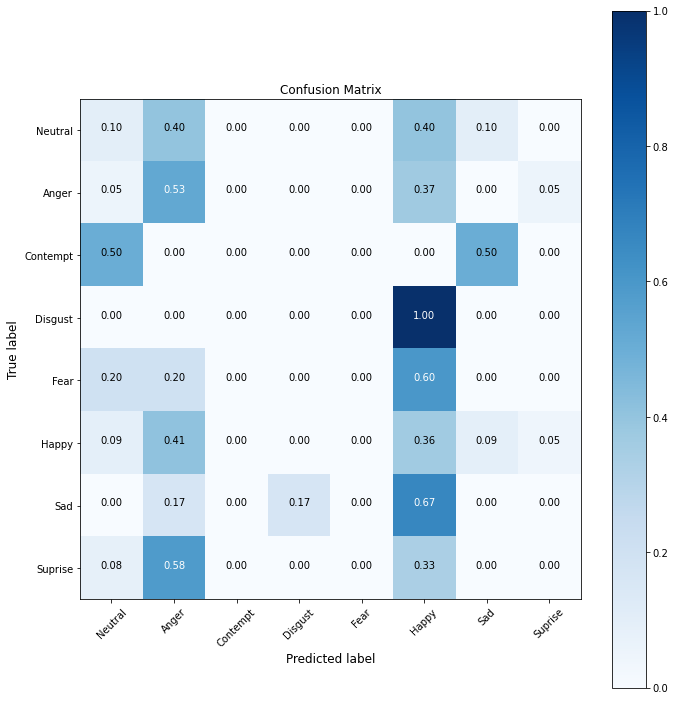

In [87]:
matrix = confusion_matrix(y_test_c3d,ans)
plot_confusion_matrix(
        matrix,
        classes=class_names,
        normalize=True,
        title='Confusion Matrix')

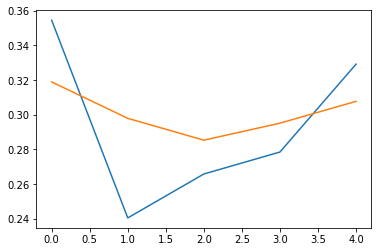

In [88]:
plt.figure()
plt.plot(c3d.history.history['val_accuracy'])
plt.plot(c3d.history.history['accuracy'])